In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Beautiful format for float type
pd.set_option('display.float_format', lambda x: '%.3f' % x)

account_info = pd.read_csv('account_info.csv')
account_txn = pd.read_csv('account_transaction.csv')
data_training = pd.read_csv('tj_04_training.csv', header=None, names=["account_no", "account_type"])
data_test = pd.read_csv('tj_04_test.csv', header=None, names=["account_no"])

In [50]:
vs = data_training.join(account_info.set_index('account_no'), on='account_no').drop(['cls_dt', 'pos_dt'], axis=1)
vs.head()

,account_no,account_type,opn_dt,drmt_dys
0,3450002243,sa,2016-02-03 00:00:00.0,0
1,3450013179,sa,2011-05-23 00:00:00.0,0
2,3450005173,sa,2016-06-14 00:00:00.0,1
3,3450034206,sa,2014-05-15 00:00:00.0,3
4,3450033428,sa,2009-02-19 00:00:00.0,0


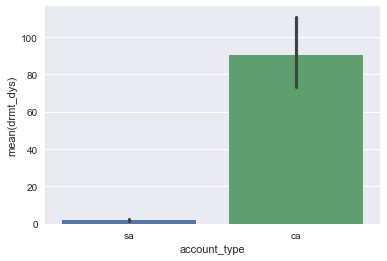

In [51]:
sns.barplot(data=vs, x='account_type', y='drmt_dys')

In [37]:
vs.drmt_dys.mean()

46.381250000000001

In [3]:
account_info.info()
print('\n')
account_txn.info()
# data_training.info()
# data_test.info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 5 columns):
account_no    5400 non-null int64
pos_dt        5400 non-null object
opn_dt        5400 non-null object
cls_dt        95 non-null object
drmt_dys      5400 non-null int64
dtypes: int64(2), object(3)
memory usage: 211.0+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797089 entries, 0 to 797088
Data columns (total 6 columns):
account_no          797089 non-null int64
fm_to_account_no    797089 non-null int64
txn_amt             797089 non-null int64
txn_dt              797089 non-null object
txn_tm              0 non-null float64
txn_type            797089 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 36.5+ MB


In [52]:
account_info = account_info.drop('cls_dt', axis=1) # Drop cls_dt column, they are all NULL value
account_txn = account_txn.drop('txn_tm', axis=1) # Drop txn_tm column, they are all NULL value

In [53]:
account_info['pos_dt'] = pd.to_datetime(account_info['pos_dt']) # Clean timestamp to only date
account_info['opn_dt'] = pd.to_datetime(account_info['opn_dt']) # Clean timestamp to only date
account_info.sort_values('account_no').head()

,account_no,pos_dt,opn_dt,drmt_dys
3687,3450000004,2016-10-31,2003-07-11,3
5371,3450000020,2016-10-31,2015-07-20,5
3873,3450000023,2016-10-31,2015-07-20,0
4066,3450000025,2016-10-31,2015-07-20,0
2959,3450000026,2016-10-31,2015-07-20,217


In [54]:
account_txn['txn_dt'] = pd.to_datetime(account_txn['txn_dt']) # Clean timestamp to only date
account_txn.sort_values('account_no').head()

,account_no,fm_to_account_no,txn_amt,txn_dt,txn_type
169006,3450000004,0,500,2016-05-30,CR
355983,3450000004,0,200,2016-04-29,DR
15941,3450000004,0,500,2016-04-28,CR
313630,3450000004,0,200,2016-05-31,DR
79473,3450000004,0,500,2016-06-29,CR


In [55]:
transaction_per_day = account_txn[['account_no', 'txn_amt', 'txn_type', 'txn_dt']].groupby(['account_no', 'txn_type', 'txn_dt']).sum().reset_index()
transaction_per_day.head()

,account_no,txn_type,txn_dt,txn_amt
0,3450000004,CR,2016-04-28,500
1,3450000004,CR,2016-05-30,500
2,3450000004,CR,2016-06-29,500
3,3450000004,CR,2016-09-28,500
4,3450000004,DR,2016-04-29,200


In [56]:
transaction_per_day_pivot = transaction_per_day.pivot_table(values = 'txn_amt'
                                                      , columns = 'txn_type'
                                                      , index = 'account_no'
                                                      , aggfunc = np.sum
                                                      , fill_value = 0
                                                     ).reset_index()
transaction_per_day_pivot.columns.name = None
transaction_per_day_pivot=transaction_per_day_pivot.rename(columns = {'CR':'CR_total', 'DR':'DR_total'})
transaction_per_day_pivot.head()

,account_no,CR_total,DR_total
0,3450000004,2000,800
1,3450000020,1336100,1227200
2,3450000023,279900,535200
3,3450000025,727100,2256200
4,3450000026,93900,166400


In [57]:
transaction_per_day_pivot_2 = transaction_per_day.pivot_table(values = 'txn_dt'
                                                      , columns = 'txn_type'
                                                      , index = 'account_no'
                                                      , aggfunc = np.size
                                                      , fill_value = 0
                                                     ).reset_index()
transaction_per_day_pivot_2.columns.name = None
transaction_per_day_pivot_2=transaction_per_day_pivot_2.rename(columns = {'CR':'CR_times', 'DR':'DR_times'})
transaction_per_day_pivot_2.head()

,account_no,CR_times,DR_times
0,3450000004,4,4
1,3450000020,14,15
2,3450000023,2,2
3,3450000025,12,21
4,3450000026,3,7


In [58]:
transaction_drmt_days = account_info[['account_no', 'drmt_dys',]].groupby(['account_no']).sum().reset_index()
transaction_drmt_days.head()

,account_no,drmt_dys
0,3450000004,3
1,3450000020,5
2,3450000023,0
3,3450000025,0
4,3450000026,217


In [59]:
account_txn_summary = transaction_per_day_pivot.join(transaction_per_day_pivot_2.set_index('account_no'), on='account_no', how='left').join(transaction_drmt_days.set_index('account_no'), on='account_no')
account_txn_summary.head()

,account_no,CR_total,DR_total,CR_times,DR_times,drmt_dys
0,3450000004,2000,800,4,4,3
1,3450000020,1336100,1227200,14,15,5
2,3450000023,279900,535200,2,2,0
3,3450000025,727100,2256200,12,21,0
4,3450000026,93900,166400,3,7,217


In [60]:
data_training.loc[data_training["account_type"] == "sa", "account_type"] = 0
data_training.loc[data_training["account_type"] == "ca", "account_type"] = 1
data_training.head(6)

,account_no,account_type
0,3450002243,0
1,3450013179,0
2,3450005173,0
3,3450034206,0
4,3450033428,0
5,3450013510,1


In [38]:
mean = account_txn_summary.drmt_dys.mean()
account_txn_summary.loc[account_txn_summary.drmt_dys < mean, "drmt_dys"] = 0
account_txn_summary.loc[account_txn_summary.drmt_dys >= mean, "drmt_dys"] = 1

In [67]:
data_features = account_txn_summary.join(data_training.set_index('account_no'), on='account_no', how='left')
# data_features = data_features.dropna(axis=0, how='any')
# data_features = data_features.drop(['CR_total', 'DR_total', 'CR_times', 'DR_times'], axis=1)
data_features = data_features.reset_index(drop=True)
data_features.head()

,account_no,CR_total,DR_total,CR_times,DR_times,drmt_dys,account_type
0,3450000004,2000,800,4,4,3,1
1,3450000020,1336100,1227200,14,15,5,NaN
2,3450000023,279900,535200,2,2,0,1
3,3450000025,727100,2256200,12,21,0,1
4,3450000026,93900,166400,3,7,217,1


In [122]:
from sklearn.model_selection import train_test_split

training_data_features = data_features.dropna(axis=0, how='any')
X_all = training_data_features.drop(['account_no', 'account_type'], axis=1).astype(int)
y_all = training_data_features['account_type'].astype(int)

num_test = 0.30
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = num_test, random_state = 23)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()
# clf = KNeighborsClassifier()

def run_kfold(clf):
    kf = KFold(training_data_features.shape[0], n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

clf.fit(X_all, y_all)

Fold 1 accuracy: 0.8518518518518519
Fold 2 accuracy: 0.8472222222222222
Fold 3 accuracy: 0.8796296296296297
Fold 4 accuracy: 0.8634259259259259
Fold 5 accuracy: 0.8726851851851852
Fold 6 accuracy: 0.8773148148148148
Fold 7 accuracy: 0.9189814814814815
Fold 8 accuracy: 0.8611111111111112
Fold 9 accuracy: 0.8495370370370371
Fold 10 accuracy: 0.8425925925925926
Mean Accuracy: 0.8664351851851851


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [124]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.986111111111


In [123]:
clf.score(X_train, y_train), clf.score(X_all, y_all)

(0.98776455026455023, 0.98726851851851849)

In [74]:
# Choose the type of classifier. 
random_forest = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [500], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 15], 
              'min_samples_split': [2, 3, 5, 8],
              'min_samples_leaf': [1,5,8, 10]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(random_forest, parameters, scoring=acc_scorer, n_jobs=6)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
random_forest = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)
print(accuracy_score(y_test, predictions))

0.880787037037


In [116]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split


adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
predictions = adaboost.predict(X_test)
acc_adaboost_train = round(adaboost.score(X_train, y_train) * 100, 2)
acc_adaboost_test = round(adaboost.score(X_test, y_test) * 100, 2)
acc_adaboost = acc_adaboost_train, acc_adaboost_test

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log_train = round(logreg.score(X_train, y_train) * 100, 2)
acc_log_test = round(logreg.score(X_test, y_test) * 100, 2)
acc_log = acc_log_train, acc_log_test

svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc_train = round(svc.score(X_train, y_train) * 100, 2)
acc_svc_test = round(svc.score(X_test, y_test) * 100, 2)
acc_svc = acc_svc_train, acc_svc_test

knn = KNeighborsClassifier(n_neighbors = X_train.shape[1])
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn_train = round(knn.score(X_train, y_train) * 100, 2)
acc_knn_test = round(knn.score(X_test, y_test) * 100, 2)
acc_knn = acc_knn_train, acc_knn_test

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian_train = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian_test = round(gaussian.score(X_test, y_test) * 100, 2)
acc_gaussian = acc_gaussian_train, acc_gaussian_test

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron_train = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron_test = round(perceptron.score(X_test, y_test) * 100, 2)
acc_perceptron = acc_perceptron_train, acc_perceptron_test


linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc_train = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc_test = round(linear_svc.score(X_test, y_test) * 100, 2)
acc_linear_svc = acc_linear_svc_train, acc_linear_svc_test

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd_train = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd_test = round(sgd.score(X_test, y_test) * 100, 2)
acc_sgd = acc_sgd_train, acc_sgd_test

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree_train = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)
acc_decision_tree = acc_decision_tree_train, acc_decision_tree_test

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest_test = round(random_forest.score(X_test, y_test) * 100, 2)
acc_random_forest = acc_random_forest_train, acc_random_forest_test

models = pd.DataFrame({
    'Model': ['Support Vector Machines'
              , 'KNN'
              , 'Logistic Regression'
              , 'Random Forest'
              , 'Naive Bayes'
              , 'Perceptron'
              , 'Stochastic Gradient Decent'
              , 'Linear SVC'
              , 'Decision Tree'
              , 'AdaBoost'],
    'Score': [acc_svc
              , acc_knn
              , acc_log
              , acc_random_forest
              , acc_gaussian
              , acc_perceptron
              , acc_sgd
              , acc_linear_svc
              , acc_decision_tree
              , acc_adaboost]})
models['Train Score'] = models.Score.apply(lambda x: x[0])
models['Test Score'] = models.Score.apply(lambda x: x[1])
models = models.drop('Score', axis = 1)

models.sort_values(by = 'Test Score', ascending = False)

,Model,Train Score,Test Score
3,Random Forest,100.000,87.380
9,AdaBoost,89.210,87.040
8,Decision Tree,100.000,80.670
2,Logistic Regression,73.290,73.030
1,KNN,78.360,68.170
7,Linear SVC,53.880,53.360
0,Support Vector Machines,100.000,52.890
5,Perceptron,49.650,51.390
4,Naive Bayes,53.040,51.160
6,Stochastic Gradient Decent,44.130,42.710


In [ ]:
test_data_features = data_test.join(data_features.set_index('account_no'), on = 'account_no', how = 'left')
test_data_features.head()

In [92]:
test = data_test.join(account_txn_summary.set_index('account_no'), on='account_no', how='left')

predictions = clf.predict(test.drop(['account_no'], axis = 1))

output = pd.DataFrame({'account_type': predictions })
output.loc[output['account_type'] == 0] = 'sa'
output.loc[output['account_type'] == 1] = 'ca'
output.to_csv('4.txt', index = False, header = None)
output.head(10)

,account_type
0,sa
1,ca
2,sa
3,sa
4,ca
5,sa
6,ca
7,sa
8,sa
9,sa
